In [1]:
import sys
lib_path = '/home/jovyan/libs'
sys.path.insert(0, lib_path)

In [8]:
%reload_ext autoreload
%autoreload 2

import gc, math, traceback, datetime

import numpy as np

import torch
from datasets import load_from_disk
from transformers import WhisperForConditionalGeneration, WhisperProcessor

from utils import attention

In [103]:
model, processor = attention.init()
model.eval();

In [104]:
snippet_path = "tensors/snippets.pt"

snippets = torch.load(snippet_path, weights_only=True).detach()
best_snippet = snippets[-1]

In [159]:
SEED = 1
SELECT = 250
data = load_from_disk("../tedlium/test.hf").with_format("torch").shuffle(seed=SEED).select(range(SELECT))

In [160]:
hehe = data[2]
example = hehe["audio"]
print(hehe["text"])

unfortunately it 's not much better i find the the last two words under near antonyms particularly unsettling whole and wholesome


In [161]:
attacked_example = torch.concat([best_snippet, example])

meaned = torch.full(best_snippet.shape, torch.mean(torch.abs(example)))
meaned_example = torch.concat([meaned, example])

In [162]:
meaned

tensor([0.0194, 0.0194, 0.0194,  ..., 0.0194, 0.0194, 0.0194])

In [163]:
attacked_example = torch.concat([best_snippet, example])

meaned = torch.full(best_snippet.shape, torch.mean(torch.abs(example)))
meaned_example = torch.concat([meaned, example])

decoded_attacked, res_attacked, _, e_attns_attacked, _, c_attns_attacked = attention.inference(attacked_example, model, processor, skip_special_tokens=True)
decoded_meaned, res_meaned, _, e_attns_meaned, _, c_attns_meaned = attention.inference(meaned_example, model, processor, skip_special_tokens=True)

In [164]:
encoder_limit = int((example.size(0) + snippets.size(1)) / 16000 * 50) + 1

# Attacked

In [165]:
decoded_attacked

' .'

Indices: [519]


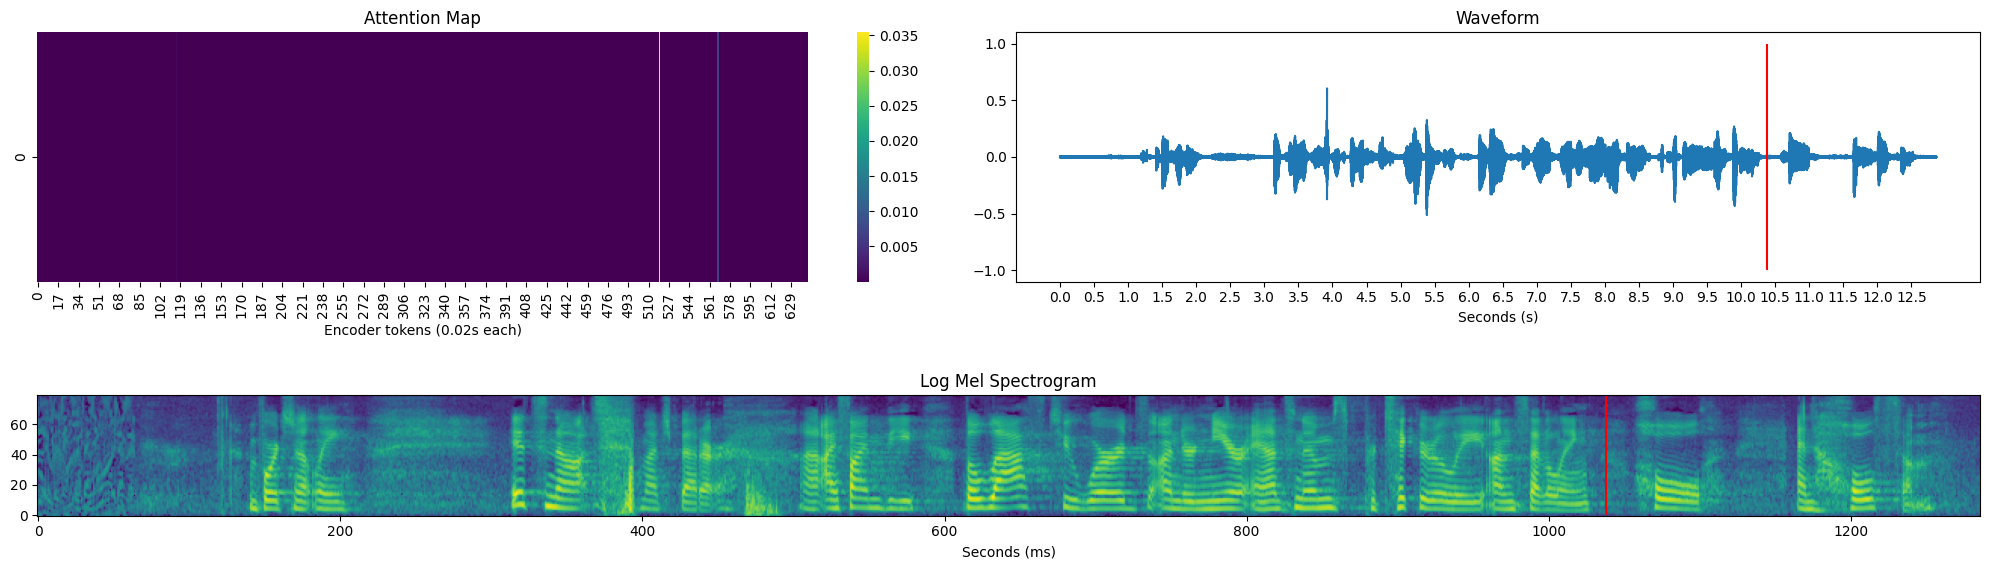

In [166]:
c_attns_stacked_cutoff = torch.stack([torch.stack(c).squeeze() for c in c_attns_attacked[1:]]).permute(1, 2, 0, 3)[:, :, :, :encoder_limit][0, 2]
attention.plot_spikes(attacked_example, c_attns_stacked_cutoff, lim=0.5)

In [149]:
# e_attns_stacked_cutoff = torch.stack(e_attns_attacked).squeeze()[:, :, :, :encoder_limit][0, 2]
# attention.plot_spikes(attacked_example, e_attns_stacked_cutoff, lim=0.5)

# Meaned

In [167]:
decoded_meaned

" Unfortunately, it's not much better. I find the last two words under near antinims, particularly unsettling, whole and wholesome."

Indices: [116, 519, 568]


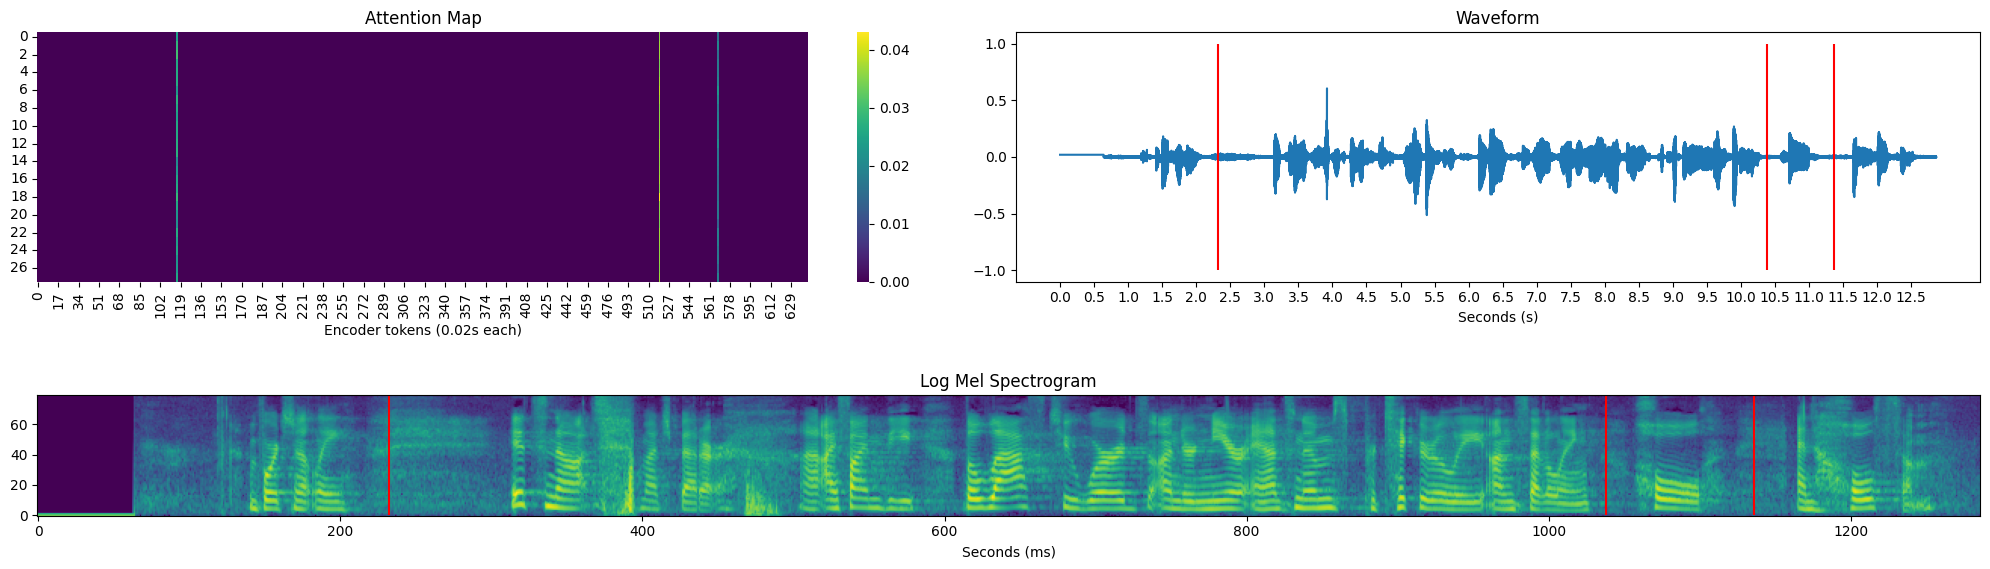

In [168]:
c_attns_stacked_cutoff = torch.stack([torch.stack(c).squeeze() for c in c_attns_meaned[1:]]).permute(1, 2, 0, 3)[:, :, :, :encoder_limit][0, 2]
attention.plot_spikes(meaned_example, c_attns_stacked_cutoff, lim=0.5)